<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")


Training results should now be reproducible.


# Train model

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.001,
    "weight_decay": 0,
    "name": "adam"
  },
  "n_epochs": 3,
  "freeze_layers": true,
  "augmentation": {
    "enabled": false,
    "dropout_rate": 0.3
  },
  "validation_freq": 1,
  "mft": {
    "enabled": false,
    "k": 0
  },
  "fixmatch": false,
  "unsup_weight": 0.5,
  "contrastive_temp": 0.1,
  "num_classes": 37,
  "use_scheduler": false
}
Training result:
{
  "training_losses": [0.4666241758292721, 0.08900687342850111, 0.07484494892740122],
  "training_accuracies": [0.9063136456211812, 0.9864222674813307, 0.9860828241683639],
  "validation_accuracies": [0.9863760217983651, 0.9863760217983651, 0.9904632152588556],
  "update_steps": [93, 186, 279],
  "epochs": [1, 2, 3],
  "training_elapsed": 37.397552294998604,
  "training_pre_loop_elapsed": 0.013336388998141047
}


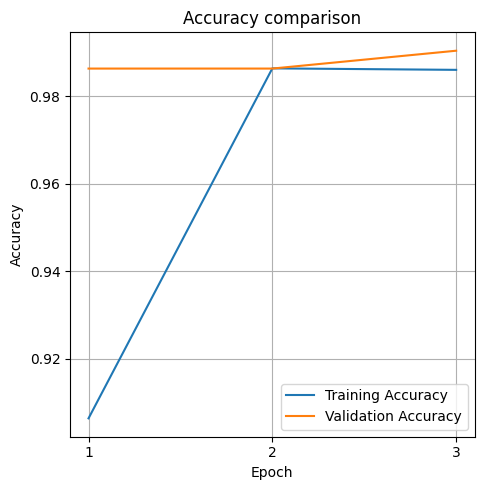

In [2]:
%reload_ext autoreload
%autoreload 2

from augmentation import AugmentationParams
from training import TrainParams, AdamParams
from evaluation import evaluate_with_train_val_plot
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    validation_set_fraction=0.2,
    target_types="binary-category",
)

baseline_params = TrainParams(
    seed=determinism.seed,
    architecture="resnet50",
    n_epochs=3,
    optimizer=AdamParams(
        learning_rate=1e-3,
        weight_decay=0,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    augmentation=AugmentationParams(
        enabled=False,
        transform=None,
    ),
)

run_args = (dataset_params, baseline_params, determinism)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

# Test model

In [3]:
from evaluation import evaluate_final_test_accuracy

evaluate_final_test_accuracy(dataset_params, baseline_params, determinism, trials=10)

Test size: 3669
Trying to load trainer from disk...
[Trainer] Loaded checkpoint from runs/checkpoints/64896c8c61855bae672c31e0b3f2ec6e.pth (epoch 3)


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 99.128 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4759, Train Acc: 90.50%, Val Acc: 98.50%
Epoch [2/3], Loss: 0.0891, Train Acc: 98.57%, Val Acc: 98.37%
Epoch [3/3], Loss: 0.0772, Train Acc: 98.34%, Val Acc: 98.91%
Total elapsed: 36.23s, average per update step: 0.09s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 99.182 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4806, Train Acc: 89.71%, Val Acc: 98.64%
Epoch [2/3], Loss: 0.0930, Train Acc: 98.78%, Val Acc: 98.77%
Epoch [3/3], Loss: 0.0799, Train Acc: 98.54%, Val Acc: 99.05%
Total elapsed: 36.41s, average per update step: 0.09s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 99.182 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4879, Train Acc: 89.92%, Val Acc: 98.37%
Epoch [2/3], Loss: 0.0903, Train Acc: 98.61%, Val Acc: 98.64%
Epoch [3/3], Loss: 0.0749, Train Acc: 98.64%, Val Acc: 98.64%
Total elapsed: 36.64s, average per update step: 0.08s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 99.101 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4676, Train Acc: 90.84%, Val Acc: 98.37%
Epoch [2/3], Loss: 0.0871, Train Acc: 98.78%, Val Acc: 98.37%
Epoch [3/3], Loss: 0.0764, Train Acc: 98.64%, Val Acc: 98.64%
Total elapsed: 36.66s, average per update step: 0.08s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 99.210 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4547, Train Acc: 91.79%, Val Acc: 98.50%
Epoch [2/3], Loss: 0.0871, Train Acc: 98.64%, Val Acc: 98.50%
Epoch [3/3], Loss: 0.0758, Train Acc: 98.68%, Val Acc: 98.77%
Total elapsed: 36.62s, average per update step: 0.08s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 99.128 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4706, Train Acc: 91.04%, Val Acc: 98.50%
Epoch [2/3], Loss: 0.0860, Train Acc: 98.85%, Val Acc: 98.50%
Epoch [3/3], Loss: 0.0782, Train Acc: 98.57%, Val Acc: 98.77%
Total elapsed: 36.63s, average per update step: 0.09s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 99.237 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4600, Train Acc: 92.23%, Val Acc: 98.64%
Epoch [2/3], Loss: 0.0881, Train Acc: 98.57%, Val Acc: 98.77%
Epoch [3/3], Loss: 0.0726, Train Acc: 98.91%, Val Acc: 98.91%
Total elapsed: 36.43s, average per update step: 0.09s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 99.155 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4723, Train Acc: 91.41%, Val Acc: 98.23%
Epoch [2/3], Loss: 0.0893, Train Acc: 98.81%, Val Acc: 98.50%
Epoch [3/3], Loss: 0.0752, Train Acc: 98.68%, Val Acc: 98.77%
Total elapsed: 36.82s, average per update step: 0.08s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 99.210 %
Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4852, Train Acc: 89.78%, Val Acc: 98.23%
Epoch [2/3], Loss: 0.0909, Train Acc: 98.61%, Val Acc: 98.64%
Epoch [3/3], Loss: 0.0759, Train Acc: 98.78%, Val Acc: 98.77%
Total elapsed: 36.42s, average per update step: 0.09s


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 99.128 %
Test Accuracy Mean: 99.17 %
Test Accuracy Standard Error: 0.01 percentage points
